In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

# Описание [датасета](https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats/data) с Kaggle


### Контекст

Этот набор данных содержит результаты A/B тестирования в игре Cookie Cats для изучения того, что происходит, когда первый gate уровень в игре перемещаются с 30-го на 40-й уровень. Когда игрок устанавливал игру, ему случайным образом назначалось значение: либо gate_30, либо gate_40.

### Данные

У нас есть данные о 90 189 игроках, которые установили игру во время выполнения A/B-теста. 

### Переменные

- **userid:** Уникальный номер, который идентифицирует каждого игрока.
- **version:** Был ли игрок включен в контрольную группу (gate_30 - gate на 30-м уровне) или в группу со сдвигом gate уровня (gate_40 - gate на 40-м уровне).
- **sum_gamerounds:** количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки.
- **retention_1:** Вернулся ли игрок и сыграл ли он через 1 день после установки? (бинарная)
- **retention_7:** Возвращался ли игрок к игре через 7 дней после установки? (бинарная)

Когда игрок устанавливал игру, он или она были случайным образом были опредлены в группу (или gate_30, или gate_40).

**Так как в описании набора данных, не хватает полного описания самого теста, я попробовал задизайнить этот A/B полноценно. Возможно домысливая в некоторых местах.**

# Дизайн эксперимента

## Суть эксперимента

### Бизнес-проблема

У нас есть игра Cookie Cats. В ней есть gate уровни - это особые уровени, на которых игрок сталкивается с определенным барьером или испытанием, которое необходимо преодолеть для продвижения дальше. Мы хотим, чтобы пользователи, играли в игру больше, поэтому попробуем перенсти gate уровень дальше. 



### Гипотеза

**Если** перенести gate уровень с 30 на 40

**Тогда** это увеличит число сыгранных раундов на XX (нужно обсуждать!),

**Потому что** gate уровень обладает большой сложностью и это позволит пользователям играть дольше не испытвая особенных трудностей в прохождении игры

## Метрики

Исходя из доступных нам данных в эксперименте будем использовать число игровых раундов. В качестве нулевой гипотезы будет равенство средних. Также используем дополнительные метрики: retention за 1 и за 7 дней. Для числа раундов будем использовать следующий критерий: T-тест или Mann-Whitney, а для retention используем бутстрап.
 

## Принятие решения

- **Критерий успеха:** Увеличение числа сыгранных раундов на XX или более, при статистически значимом результате (p-value < 0.05) и без ухудшения дополнительных метрик.

- **Критерий провала:** Отсутствие статистически значимого увеличения доли вернувшихся пользователей или статистически значимое уменьшение доли вернувшихся пользоватлей, или значительное ухудшение дополнительных метрик.

## Аудитория

- **Географические ограничения:** Проводим эксперимент во всех регионах, где есть достаточное количество пользователей для получения значимых результатов.
- **Платформы:** Эксперимент проводится для пользоватлей ПК и в мобильном приложении, чтобы учесть всех пользователей.
- **Версия приложения:** ХХ и выше.
- **Источник трафика:** Включаем все источники трафика (прямые визиты, органический поиск, платная реклама и т.д.).
- **Тип пользователей:** Эксперимент проводится на новых пользователях.

## Группы

- группа А – контроль (gate_30): 50% аудитории.
- группа Б – тест (gate_40): 50% аудитории.

## Размер выборки и время

После этого можно было бы расчитать размер выборки (Sample Size).

Зная, базовое число сыгранных раундов = ХX, MDE = X и стандартные уровни значимости ($\alpha$ = 0.05) и мощности (1 - $\beta$ = 0.8).

Ожидаемую дату окончания можно расчитать по формуле:

$$\frac{2N}{DAU},$$
где N - объем нашей выборки.

Или наоборот можем катить на 1 или 2 недели, тогда считаем MDE.

## Даты

Здесь определяем даты и время проведения теста.


### Применение методов снижения дисперсии

Также стоит отметь некоторые методы, которые используются при A/B тестировании для снижения дисперсии:

- Удаление выбросов
- Стратификация сэмплирования
- CUPED




# Разведочный анализ данных

In [75]:
df = pd.read_csv('cookie_cats.csv' )
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [76]:
df.shape

(90189, 5)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


У нас нет пропущенных значений.

#### Посмотрим на распределение групп

In [78]:
df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

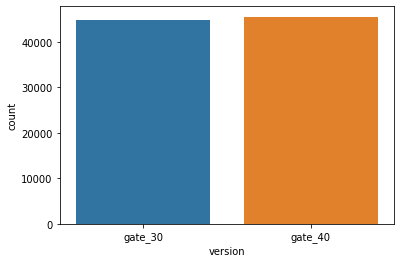

In [79]:
sns.countplot(data=df, x='version');

Группы почти равные.

#### Посмотрим на распределение сыгранных уровней

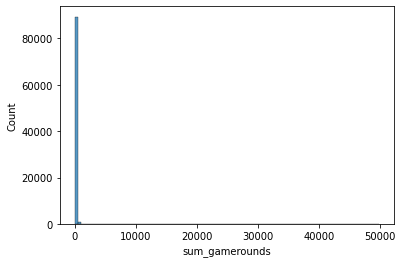

In [80]:
sns.histplot(df, x='sum_gamerounds', bins=100);

График выглядит странно. Число уровней доходит до 50000 за 2 недели. Посмотрим на данные в разрезе по уровню gate и в табличном виде.

In [81]:
stats = pd.concat([df[df['version']=='gate_30'].describe(percentiles=[.90, .95, .99]).T. \
                   iloc[1:].reset_index().rename(columns={'index': 'name'}),
         df[df['version']=='gate_40'].describe(percentiles=[.90, .95, .99]).T. \
                   iloc[1:].reset_index().rename(columns={'index': 'name'})]).reset_index()

stats.loc[0, 'name'] = 'gate_30'
stats.loc[1, 'name'] = 'gate_40'
stats

,index,name,count,mean,std,min,50%,90%,95%,99%,max
0,0,gate_30,44700.0,52.456264,256.716423,0.0,17.0,135.0,222.0,493.00,49854.0
1,0,gate_40,45489.0,51.298776,103.294416,0.0,16.0,134.0,220.0,492.12,2640.0


Можно заметить следующие результаты:
- В группе gate_30 максимальное число уровней доходит до 49854.
- Среднее значение выше в групе gate_30. Нужно выяснить статистически значимы эти различия или нет.
- Есть пользователи с 0 пройденных уровней. Много ли таких?
- Стандартное отклонение гораздо больше в группе gate_30. Возможно это из-за аномально высокого максимального значения.

Посмотрим на макисмальное число сыгранных уровней. Отсортируем df по числу сыгранных уровней.

In [82]:
df.sort_values(by='sum_gamerounds', ascending=False).head()

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True


Такой человек всего 1. Пройти 2961 уровень за 2 недели кажется возможным, а вот почти 50000 уровней нереально. Скорее всего этот игрок использовал читы, поэтому исключим его из рассмотрения. 

In [83]:
df = df[df['sum_gamerounds'] != 49854]

Посчитаем теперь сколько человек никогда не запускали игру.

In [84]:
print(str(round(df[df['sum_gamerounds'] == 0].shape[0] / df.shape[0] * 100, 2)) + '% игроков никогда не запускали игру.')

4.43% игроков никогда не запускали игру.


Таких игроков относительно немного.

#### Посмотрим на retention

In [87]:
df.groupby('version', as_index=False).agg({'retention_1': 'mean', 'retention_7': 'mean'})

,version,retention_1,retention_7
0,gate_30,0.448198,0.190183
1,gate_40,0.442283,0.182000


Retention выше у группы gate_30, причем и за 1 день, и за 7 дней. Остается выясмнить являются ли эти различия статистически значимыми.

# Анализ результатов A/B теста

## Анализ для числа сыгранных раундов

Для применения T-теста наблюдения должны быть независимы и выборочные средние нормально распределены. Наблюдения у нас независимы по построению нашей выборки. Проверим нормальность распределения выборочных средних с помощью теста Шапиро-Уилка. Для этого возьмем 1000 раз выборку в 1000 элементов из наших данных по каждой группе и посчитаем средние значения по кажой выборке. К получившимся массивам применим критерий Шапиро-Уилка.

In [88]:
means_A = []
means_B = []
i = 0

while i < 1000:
    sample_A = np.random.choice(df[df['version'] == 'gate_30']['sum_gamerounds'], replace=True, size=1000)
    sample_B = np.random.choice(df[df['version'] == 'gate_40']['sum_gamerounds'], replace=True, size=1000)
    means_A.append(sample_A.mean())
    means_B.append(sample_B.mean())
    i += 1

In [91]:
print('p-value для группы gate_30:', st.shapiro(means_A)[1])
print('p-value для группы gate_40:', st.shapiro(means_B)[1])

p-value для группы gate_30: 0.02163967676460743
p-value для группы gate_40: 0.029699472710490227


p-value меньше 0.05 в обоих случаях, значит мы не можем принять гипотезу о том, что данные нормально распределены.

Тогда используем тест Манна-Уитни.

In [98]:
st.mannwhitneyu(df[df["version"] == "gate_30"]["sum_gamerounds"],
                            df[df["version"] == "gate_40"]["sum_gamerounds"])
print("p-value теста Манна-Уитни:", st.mannwhitneyu(df[df["version"] == "gate_30"]["sum_gamerounds"],
                            df[df["version"] == "gate_40"]["sum_gamerounds"])[1])

p-value теста Манна-Уитни: 0.05089155279145376


Как мы видели, среднее значение сыгранных раундов ухудшилось в группе gate_40. Теперь можно добавить что это ухудшение не является статистически значимым, согласно тесту Манна-Уитни p-value получилось больше 0.05 и мы не можем отклонить нулевую гипотезу о равенстве средних.

## Анализ для retention

Используем бутстрап для анализа retention:

1. Сгенерируем 1000 псевдовыборок с возвращением из нашей
2. Вычисляем 1-дневный и 7-дневный retention для кажой из групп
3. Построим полученные распределения
4. Вычислим разницу между группами
5. Вычислим вероятность retention быть выше для группы gate_30 (ранее видели, что retention в этой группе выше)

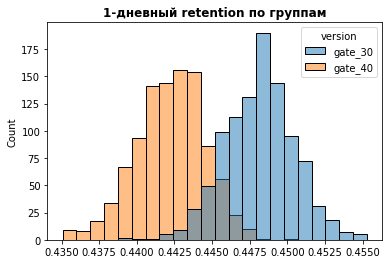

In [128]:
retention_1 = []
retention_7 = []

for i in range(1000):
    mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    retention_1.append(mean_1)
    retention_7.append(mean_7)
    
retention_1 = pd.DataFrame(retention_1)
retention_7 = pd.DataFrame(retention_7)

sns.histplot(retention_1).set_title("1-дневный retention по группам", fontweight="semibold",size=12);

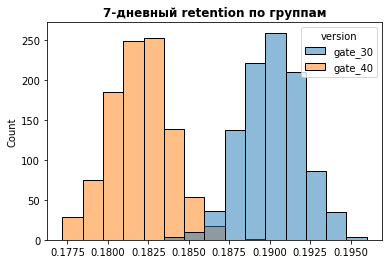

In [127]:
sns.histplot(retention_7).set_title("7-дневный retention по группам", fontweight="semibold",size=12);

Посмотрим теперь на разность распределений.

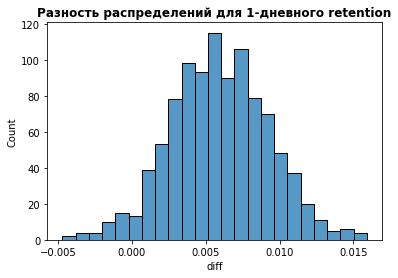

In [129]:
retention_1['diff'] = retention_1['gate_30'] - retention_1['gate_40']
retention_7['diff'] = retention_7['gate_30'] - retention_7['gate_40']

sns.histplot(retention_1['diff']).set_title("Разность распределений для 1-дневного retention", fontweight="semibold",size=12);

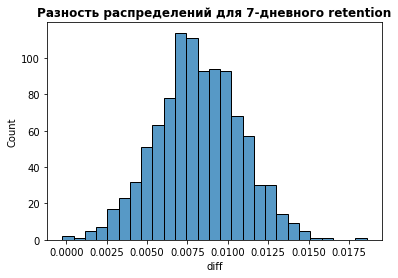

In [131]:
sns.histplot(retention_7['diff']).set_title("Разность распределений для 7-дневного retention", fontweight="semibold",size=12);

Как можно заметить разность распределений для 7-дневного retention почти не пересекает 0. То есть в этом случае почти всегда будет лучше группа gate_30. Для 1-дневного retention разница в основном больше 0. Посчитаем вероятности этой метрики быть больше в группе gate_30.

In [132]:
prob_1 = (retention_1['diff']>0).sum() / len(retention_1['diff'])
print('Вероятность значения 1-дневного retention быть больше в группе gate_30:', prob_1)

prob_7 = (retention_7['diff']>0).sum() / len(retention_7['diff'])
print('Вероятность значения 7-дневного retention быть больше в группе gate_30:', prob_7)

Вероятность значения 1-дневного retention быть больше в группе gate_30: 0.963
Вероятность значения 7-дневного retention быть больше в группе gate_30: 0.999


Обе вероятности достаточно велики и больше 95%, для 7-дневного retention вероятность почти равна 1. Таким образом, можно сделать вывод, что retention больше в группе gate_30.

# Выводы

Как мы уже видели, после введения изменения среднее значение числа сыгранных раундов изменилось в худшую сторону. Результаты теста Манна-Уитни не являются статистически значимвыми. Также новое изменение влияет на retention в худшую сторону. Результаты бутстрапа показывают ухудшения для 7-дневного retention в 99.9% случаев, а для однодневного в 96.3% случаев.

Таким образом, данная фича не рекомендуется к использованию. Лучше оставить gate на 30 уровне.